In [1]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import * 

%load_ext autoreload
%autoreload 2


niks_domain = 'NIKS'
ycf_domain = 'Y.C'

In [2]:
def load_msa(path:str='../data/arf1_cleaned.afa'):
    msa_df = FASTAFile().from_fasta(path).to_df()
    msa_arr = [list(seq) for seq in msa_df.seq]
    return msa_df.index.values, np.array(msa_arr)

index, alignment = load_msa()

In [4]:
conservation_threshold = 0.8
# Flag conserved positions as those where at least 80 percent of the sequences do not have a gap. 
is_conserved = lambda col : (col != '-').astype(int).mean() > conservation_threshold

conserved_positions = np.where([is_conserved(col) for col in alignment.T])[0]
print('Num. conserved positions:', len(conserved_positions))

alignment = alignment[:, conserved_positions]

seq = ''.join(alignment[0]) # The first entry in the alignment has the canonical NIKS domain and YXCXXXF.

niks_match = re.search(niks_domain, seq)
ycf_match = re.search(ycf_domain, seq, flags=re.DOTALL)

niks_start, niks_stop = niks_match.start(), niks_match.end()
ycf_start, ycf_stop = ycf_match.start(), ycf_match.end()

# There are some clear outliers, potentially worth discarding for a better alignment. 

Num. conserved positions: 408


In [15]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)
arf1_df = arf1_df.loc[index] # Make sure the ordering is the same.

pyl_idxs = np.where(arf1_df.has_pyl)[0]
no_pyl_idxs = np.where(~arf1_df.has_pyl)[0]

alignment_df = pd.DataFrame(alignment)
alignment_df['group'] = np.where(arf1_df.has_pyl, 'pyl', 'no_pyl')

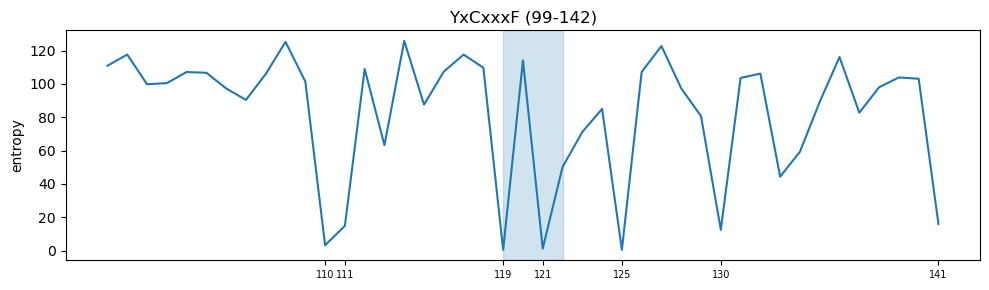

In [5]:
def figure(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=20, highlight:tuple=None, title:str=None, max_entropy:float=20):
    fig, ax = plt.subplots(figsize=(10, 3))

    alignment = alignment[:, start - delta:stop + delta] # start - delta is the new zero. 
    offset = (start - delta)

    probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
    scores = np.array([-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities])

    sns.lineplot(x=np.arange(len(scores)), y=scores, ax=ax)

    x_ticks = np.where(scores < max_entropy)[0]
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='x-small')
    ax.set_title(f'{title} ({start - delta}-{stop + delta})')
    ax.set_ylabel('entropy')

    if highlight is not None:
        x_min, x_max = highlight
        ax.axvspan(x_min - offset, x_max - offset, alpha=0.2, color='tab:blue')

    fig.tight_layout()
    plt.show()

    return np.where(scores < max_entropy)[0] + offset

# positions = figure(alignment, start=niks_start, stop=niks_stop, highlight=(niks_start, niks_stop), title='NIKS', max_entropy=20)
positions = figure(alignment, start=ycf_start, stop=ycf_stop, highlight=(ycf_start, ycf_stop), title='YxCxxxF', max_entropy=20)

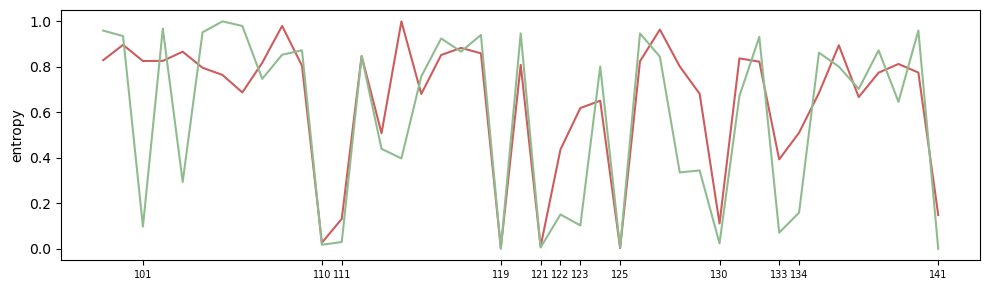

In [17]:
def figure(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=20, color:str=None, ax=None):

    alignment = alignment[:, start - delta:stop + delta] # start - delta is the new zero. 
    offset = (start - delta)

    # conserved = [np.all(column == column[0]) for column in alignment.T]
    # print('Num. completely conserved residues:', sum(conserved))

    probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
    scores = np.array([-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities])
    scores = scores / scores.max() # Normalize the scores to 1. 

    sns.lineplot(x=np.arange(len(scores)), y=scores, ax=ax, color=color)

    x_ticks = np.where(scores < 0.25)[0]
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='x-small')
    ax.set_ylabel('entropy')
    return alignment

palette = {'pyl':'darkseagreen', 'no_pyl':'indianred'}

fig, ax = plt.subplots(figsize=(10, 3))
for group, df in alignment_df.groupby('group'):
    figure(df.values, start=ycf_start, stop=ycf_stop, color=palette[group], ax=ax)
fig.tight_layout()
plt.show()

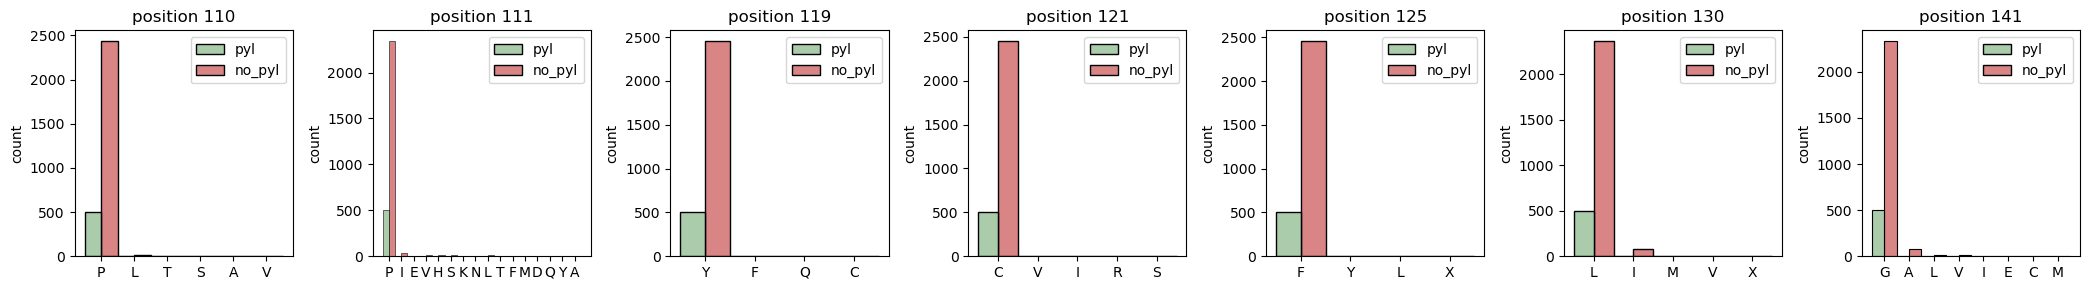

In [18]:
def figure(alignment_df:pd.DataFrame, position:int=None, palette={'pyl':'darkseagreen', 'no_pyl':'indianred'}, ax=None):
    # fig, (ax_top, ax_bottom) = get_split_figure((0, 0.0025), (0.97, 0.98))

    figure_df = alignment_df[['group', position]].copy()
    sns.histplot(figure_df, x=position, hue='group', multiple='dodge', ax=ax, palette=palette)
    ax.set_ylabel('count')
    ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')

fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure(alignment_df, position=position, ax=ax)
fig.tight_layout()
plt.show()

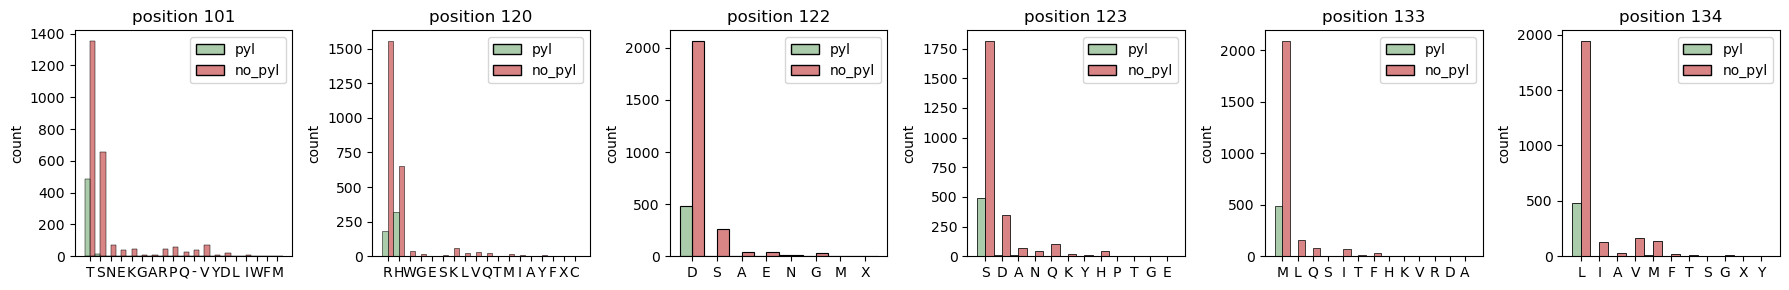

In [21]:
positions = [101, 120, 122, 123, 133, 134]
fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure(alignment_df, position=position, ax=ax)
fig.tight_layout()
plt.show()